# baseline v2

* 스케일링
    * google move mirror 스케일링 적용
    * bbox 정보를 joint 좌표값 기준으로 재생성하여 사용
        * 모델로부터 추출한 원본 bbox 좌표는 이상치 발생 가능성이 높은 프레임을 찾는 용도로 사용
        * (optional) bbox squaring, outlier joint interpolation, smoothing
* 데모 데이터셋 변경

## takeway from baseline v1

### 알고리즘 기반 특징값 추출 (기본통계량, 특잇값추출, scatterplot) 테스트
* 검증 결과 -> fail
* 알고리즘 기반 특징값은 결국 원본 데이터의 특성을 고스란히 반영
* 현 스케일링 방식은 각 이미지/포즈 데이터를 완벽하게 동일한 기준으로 통제하지 못함

### boundary box -> joint 좌표와 독립적인 프로세스로 추출됨을 확인
* bbox 정보를 joint 좌표값 기준으로 재생성하여 사용

### many-to-many 시나리오, 정말 필요할까?
현재 적용가능한 기술에 맞춰서 제약조건 추가
* 현재 사용하는 비디오 샘플은 대부분 같은 춤이지만 전혀 다른 동작이 포함되어 있으며 프레임 단위 일치하지 않음
    * 다른 동작이 포함된 상태에서 이미 통제불가능한 노이즈가 작용 -> 제대로 된 유사도 결과가 나오지 않음
* 더 구체적이고 더 좁은 user scenario 필요
    * 유저 쿼리 데이터
        * 200프레임 - 300프레임으로 제한 (최대 10초, 특정 댄스 동작 구간)
    * 매칭 데이터
        * 각 커버댄스 별 비디오는 1개만 존재한다고 가정하며 (aespa 1개, bts 1개, ...)
        * 각 비디오는 통째로 존재하지 않고, 100 ~ 600프레임 사이(최대20초)로 잘려서 데이터베이스에 존재함
    * 테스트 쿼리 데이터
        * 다른 사람이 춘 커버댄스의 특정 동작 구간 200-300프레임 (육안으로 비슷한 것을 선별)


In [1]:
import os, sys
from glob import glob
import copy

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler

import math
from scipy import spatial
from scipy.stats import kurtosis
from scipy.stats import skew
import vptree

from matplotlib import pyplot as plt
import seaborn as sns

sys.path.insert(0, "utils/")
from preprocess import make_outlier_index_dict, get_successive_groups,\
                        apply_outlier_interp, apply_one_euro_filter, rescale_by_bbox,\
                            pose_preprocess, pose_preprocess_v2, l2_norm
from distance import weighted_distance_matching, simple_minus, simple_euc, simple_cosine, cosine_dist_xy_flatten
from feature_extract import extract_feature_svd
from utils import summarize_vptree_result, rank_vptree_result, vptree_search
from visualize import visualize_joints

from visualize import multi_displot
from one_euro_filter import LowPassFilter, OneEuroFilter, OneEuroFilterROMP
from scipy.spatial.distance import cosine

### load data

In [2]:
base_dir = 'samples/npy'
pose_paths = sorted(glob(os.path.join(base_dir,'*_pose.npy')))
bbox_paths = sorted(glob(os.path.join(base_dir,'*_bbox.npy')))

print(len(pose_paths), len(bbox_paths))

poses = [np.load(pose_paths[i], allow_pickle=True)[..., :2] for i in range(len(pose_paths))]
bboxes = [np.load(bbox_paths[i], allow_pickle=True) for i in range(len(bbox_paths))]

print(len(poses), len(bboxes))

35 35
35 35


### preprocessing

### preprocess v1
* bbox padding을 전체 프레임의 pose - bbox 사이 간격들의 평균값으로 일괄 적용

In [3]:
poses1, poses1_norm = [], []
poses1_outlier_norm, poses1_outlier_smoothing_norm = [], []
idx2vidname = {}

i = 0
for pose_path, bbox_path in zip(pose_paths, bbox_paths):
    fname = os.path.basename(pose_path).split('.')[0]
    ppose = np.load(pose_path, allow_pickle=True)[...,:2]
    conf_score = np.load(pose_path, allow_pickle=True)[..., -1]
    bbox = np.load(bbox_path, allow_pickle=True)

    if bbox.dtype != 'object':
        ppose_xy = pose_preprocess(ppose, bbox, normalize=False)
        ppose_xy_norm = pose_preprocess(ppose, bbox, normalize=True)
        ppose_xy_outlier_norm = pose_preprocess(ppose, bbox, outlier_frame_interp=True, normalize=True)
        ppose_xy_outlier_smoothing_norm = pose_preprocess(ppose, bbox, outlier_frame_interp=True, smooth_coef=3.0, normalize=True)
        
        # 0~34 joint data
        # 34~51 confidence score for each (x,y)
        # 52 sum of confidence score
        # 53 video unique index
        ppose_conf = np.concatenate([ppose_xy, conf_score, 
                                    np.sum(conf_score, axis=1).reshape(-1,1),
                                    np.array([i]*len(ppose)).reshape(-1,1)], axis=1) # add video unique index
        poses1.append(ppose_conf)
        ########################################
        ppose_conf_norm = np.concatenate([ppose_xy_norm, conf_score, 
                                    np.sum(conf_score, axis=1).reshape(-1,1),
                                    np.array([i]*len(ppose)).reshape(-1,1)], axis=1) # add video unique index
        poses1_norm.append(ppose_conf_norm)
        ########################################
        ppose_conf_out_norm = np.concatenate([ppose_xy_outlier_norm, conf_score, 
                                    np.sum(conf_score, axis=1).reshape(-1,1),
                                    np.array([i]*len(ppose)).reshape(-1,1)], axis=1) # add video unique index
        poses1_outlier_norm.append(ppose_conf_out_norm)
        ########################################
        ppose_conf_out_sm_norm = np.concatenate([ppose_xy_outlier_smoothing_norm, conf_score, 
                                    np.sum(conf_score, axis=1).reshape(-1,1),
                                    np.array([i]*len(ppose)).reshape(-1,1)], axis=1) # add video unique index
        poses1_outlier_smoothing_norm.append(ppose_conf_out_sm_norm)
        ########################################
        idx2vidname[i] = fname
        i += 1
        print(fname, ppose_xy.min(), ppose_xy.max(), ppose_xy_norm.min(), ppose_xy_norm.max())
    # pose_norm_smooth = pose_preprocess(ppose, bbox, smooth_coef=3.0)
    else:
        # print(os.path.basename(pose_path), 'pass')
        continue

aespa1_frames_pose 0.054175053128689796 0.9458249468713102 0.016394378909833935 0.39027798817911147
aespa4_frames_pose 0.05462215415048513 0.9453778458495148 0.0162192776948506 0.40215096817824
bts1_frames_pose 0.046170780075811095 0.9538292199241889 0.015187612549177885 0.4186247445749077
bts2_frames_pose 0.05331456702007732 0.9466854329799227 0.017651601679050617 0.38920481442199795
bts3_frames_pose 0.055022507421003154 0.9449774925789968 0.018058332992877103 0.37821883963864883
bts4_frames_pose 0.04472543231079235 0.9552745676892077 0.013636214343046819 0.4271520156155181
bts6_frames_pose 0.04462015266453887 0.9553798473354612 0.014443889846562518 0.399610072097539
bts7_frames_pose 0.05093994169060279 0.9490600583093972 0.016935101228978084 0.41345395834833953
itzy11_frames_pose 0.05073233546842904 0.9492676645315709 0.015520694880199077 0.3886676196985542
itzy1_frames_pose 0.05603437197349119 0.9439656280265089 0.01806097578971187 0.3765170310176311
itzy2_frames_pose 0.044739541379

In [4]:
print(idx2vidname)

{0: 'aespa1_frames_pose', 1: 'aespa4_frames_pose', 2: 'bts1_frames_pose', 3: 'bts2_frames_pose', 4: 'bts3_frames_pose', 5: 'bts4_frames_pose', 6: 'bts6_frames_pose', 7: 'bts7_frames_pose', 8: 'itzy11_frames_pose', 9: 'itzy1_frames_pose', 10: 'itzy2_frames_pose', 11: 'itzy3_frames_pose', 12: 'itzy4_frames_pose', 13: 'itzy5_frames_pose', 14: 'itzy6_frames_pose', 15: 'itzy8_frames_pose', 16: 'itzy9_frames_pose', 17: 'jenny2_frames_pose', 18: 'jenny3_frames_pose', 19: 'jenny4_frames_pose', 20: 'jenny5_frames_pose', 21: 'twice1_frames_pose', 22: 'twice3_frames_pose', 23: 'twice4_frames_pose', 24: 'twice7_frames_pose'}


### preprocess v2
* bbox padding을 개별 프레임의 pose x,y min-max 차이값을 기준으로 개별 적용

In [5]:
poses2, poses2_norm = [], []
idx2vidname = {}

i = 0
for pose_path, bbox_path in zip(pose_paths, bbox_paths):
    fname = os.path.basename(pose_path).split('.')[0]
    ppose = np.load(pose_path, allow_pickle=True)[...,:2]
    conf_score = np.load(pose_path, allow_pickle=True)[..., -1]
    bbox = np.load(bbox_path, allow_pickle=True)

    if bbox.dtype != 'object':
        ppose_xy = pose_preprocess_v2(ppose, bbox, normalize=False)
        ppose_xy_norm = pose_preprocess_v2(ppose, bbox, normalize=True)
        
        # 0~34 joint data
        # 34~51 confidence score for each (x,y)
        # 52 sum of confidence score
        # 53 video unique index
        ppose_conf = np.concatenate([ppose_xy, conf_score, 
                                    np.sum(conf_score, axis=1).reshape(-1,1),
                                    np.array([i]*len(ppose)).reshape(-1,1)], axis=1) # add video unique index
        poses2.append(ppose_conf)
        ppose_conf_norm = np.concatenate([ppose_xy_norm, conf_score, 
                                    np.sum(conf_score, axis=1).reshape(-1,1),
                                    np.array([i]*len(ppose)).reshape(-1,1)], axis=1) # add video unique index
        poses2_norm.append(ppose_conf_norm)

        idx2vidname[i] = fname
        i += 1
        print(fname, ppose_xy.min(), ppose_xy.max(), ppose_xy_norm.min(), ppose_xy_norm.max())
    # pose_norm_smooth = pose_preprocess(ppose, bbox, smooth_coef=3.0)
    else:
        # print(os.path.basename(pose_path), 'pass')
        continue

aespa1_frames_pose 0.14285714285714243 0.8571428571428575 0.039615965237936555 0.36214573434486835
aespa4_frames_pose 0.14285714285714238 0.8571428571428577 0.04025106369686119 0.3705077423615655
bts1_frames_pose 0.14285714285714246 0.8571428571428575 0.04105622620067265 0.3774570754777811
bts2_frames_pose 0.14285714285714252 0.8571428571428575 0.04090251364391217 0.3604476769166956
bts3_frames_pose 0.1428571428571426 0.8571428571428574 0.04143803162140682 0.35396533437443356
bts4_frames_pose 0.14285714285714243 0.8571428571428577 0.0392106650175475 0.3863504475390044
bts6_frames_pose 0.14285714285714224 0.8571428571428578 0.03597630996265635 0.36962572932032295
bts7_frames_pose 0.14285714285714188 0.8571428571428581 0.040757027187276376 0.37421323022668374
itzy11_frames_pose 0.1428571428571426 0.8571428571428575 0.041260372701417275 0.35589157056170523
itzy1_frames_pose 0.14285714285714243 0.8571428571428575 0.041747960533403405 0.3513892397350172
itzy2_frames_pose 0.1428571428571424 

### preprocess v3 
* preprocess v2 + outlier interpolation

In [6]:
poses3, poses3_norm = [], []
idx2vidname = {}

i = 0
for pose_path, bbox_path in zip(pose_paths, bbox_paths):
    fname = os.path.basename(pose_path).split('.')[0]
    ppose = np.load(pose_path, allow_pickle=True)[...,:2]
    conf_score = np.load(pose_path, allow_pickle=True)[..., -1]
    bbox = np.load(bbox_path, allow_pickle=True)

    if bbox.dtype != 'object':
        ppose_xy = pose_preprocess_v2(ppose, bbox, normalize=False)
        ppose_xy_norm = pose_preprocess_v2(ppose, bbox, normalize=True)
        
        # 0~34 joint data
        # 34~51 confidence score for each (x,y)
        # 52 sum of confidence score
        # 53 video unique index
        ppose_conf = np.concatenate([ppose_xy, conf_score, 
                                    np.sum(conf_score, axis=1).reshape(-1,1),
                                    np.array([i]*len(ppose)).reshape(-1,1)], axis=1) # add video unique index
        poses3.append(ppose_conf)
        ppose_conf_norm = np.concatenate([ppose_xy_norm, conf_score, 
                                    np.sum(conf_score, axis=1).reshape(-1,1),
                                    np.array([i]*len(ppose)).reshape(-1,1)], axis=1) # add video unique index
        poses3_norm.append(ppose_conf_norm)

        idx2vidname[i] = fname
        i += 1
        print(fname, ppose_xy.min(), ppose_xy.max(), ppose_xy_norm.min(), ppose_xy_norm.max())
    # pose_norm_smooth = pose_preprocess(ppose, bbox, smooth_coef=3.0)
    else:
        # print(os.path.basename(pose_path), 'pass')
        continue

aespa1_frames_pose 0.14285714285714243 0.8571428571428575 0.039615965237936555 0.36214573434486835
aespa4_frames_pose 0.14285714285714238 0.8571428571428577 0.04025106369686119 0.3705077423615655
bts1_frames_pose 0.14285714285714246 0.8571428571428575 0.04105622620067265 0.3774570754777811
bts2_frames_pose 0.14285714285714252 0.8571428571428575 0.04090251364391217 0.3604476769166956
bts3_frames_pose 0.1428571428571426 0.8571428571428574 0.04143803162140682 0.35396533437443356
bts4_frames_pose 0.14285714285714243 0.8571428571428577 0.0392106650175475 0.3863504475390044
bts6_frames_pose 0.14285714285714224 0.8571428571428578 0.03597630996265635 0.36962572932032295
bts7_frames_pose 0.14285714285714188 0.8571428571428581 0.040757027187276376 0.37421323022668374
itzy11_frames_pose 0.1428571428571426 0.8571428571428575 0.041260372701417275 0.35589157056170523
itzy1_frames_pose 0.14285714285714243 0.8571428571428575 0.041747960533403405 0.3513892397350172
itzy2_frames_pose 0.1428571428571424 

### preprocess v4
* preprocess v2 + outlier interpolation + smoothing (coef=3.0)

In [7]:
poses4, poses4_norm= [], []
idx2vidname = {}

i = 0
for pose_path, bbox_path in zip(pose_paths, bbox_paths):
    fname = os.path.basename(pose_path).split('.')[0]
    ppose = np.load(pose_path, allow_pickle=True)[...,:2]
    conf_score = np.load(pose_path, allow_pickle=True)[..., -1]
    bbox = np.load(bbox_path, allow_pickle=True)

    if bbox.dtype != 'object':
        ppose_xy = pose_preprocess_v2(ppose, bbox, normalize=False)
        ppose_xy_norm = pose_preprocess_v2(ppose, bbox, normalize=True)
        
        # 0~34 joint data
        # 34~51 confidence score for each (x,y)
        # 52 sum of confidence score
        # 53 video unique index
        ppose_conf = np.concatenate([ppose_xy, conf_score, 
                                    np.sum(conf_score, axis=1).reshape(-1,1),
                                    np.array([i]*len(ppose)).reshape(-1,1)], axis=1) # add video unique index
        poses4.append(ppose_conf)
        ppose_conf_norm = np.concatenate([ppose_xy_norm, conf_score, 
                                    np.sum(conf_score, axis=1).reshape(-1,1),
                                    np.array([i]*len(ppose)).reshape(-1,1)], axis=1) # add video unique index
        poses4_norm.append(ppose_conf_norm)

        idx2vidname[i] = fname
        i += 1
        print(fname, ppose_xy.min(), ppose_xy.max(), ppose_xy_norm.min(), ppose_xy_norm.max())
    # pose_norm_smooth = pose_preprocess(ppose, bbox, smooth_coef=3.0)
    else:
        # print(os.path.basename(pose_path), 'pass')
        continue

aespa1_frames_pose 0.14285714285714243 0.8571428571428575 0.039615965237936555 0.36214573434486835
aespa4_frames_pose 0.14285714285714238 0.8571428571428577 0.04025106369686119 0.3705077423615655
bts1_frames_pose 0.14285714285714246 0.8571428571428575 0.04105622620067265 0.3774570754777811
bts2_frames_pose 0.14285714285714252 0.8571428571428575 0.04090251364391217 0.3604476769166956
bts3_frames_pose 0.1428571428571426 0.8571428571428574 0.04143803162140682 0.35396533437443356
bts4_frames_pose 0.14285714285714243 0.8571428571428577 0.0392106650175475 0.3863504475390044
bts6_frames_pose 0.14285714285714224 0.8571428571428578 0.03597630996265635 0.36962572932032295
bts7_frames_pose 0.14285714285714188 0.8571428571428581 0.040757027187276376 0.37421323022668374
itzy11_frames_pose 0.1428571428571426 0.8571428571428575 0.041260372701417275 0.35589157056170523
itzy1_frames_pose 0.14285714285714243 0.8571428571428575 0.041747960533403405 0.3513892397350172
itzy2_frames_pose 0.1428571428571424 

## visualize pose sequence

### non normalized
* v1, v2, v3, v4

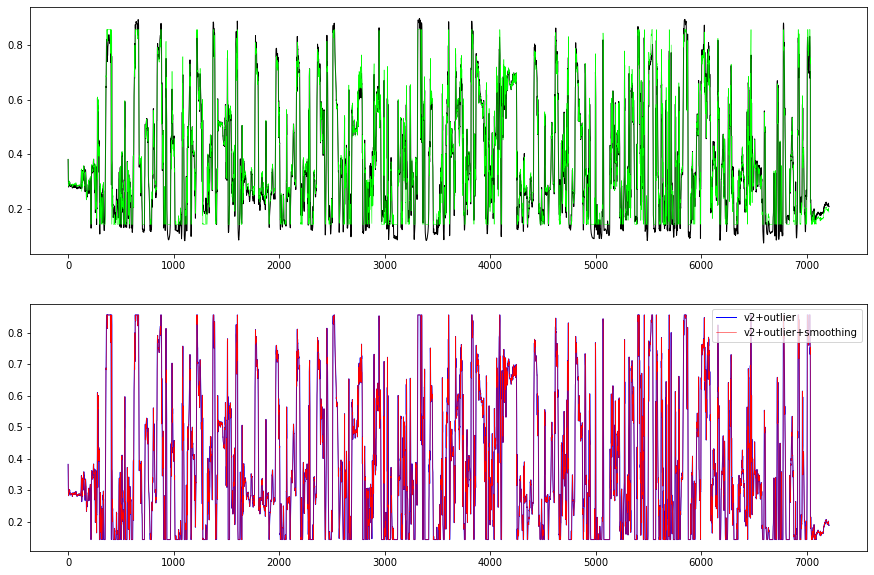

In [8]:
VIDEO_INDEX = 0
JOINT_INDEX = 10
X_OR_Y = 'x'
POSE_LIST = [poses1, poses2, poses3, poses4]
######
pose_list = [p[VIDEO_INDEX][...,:34].reshape(-1,17,2) for p in POSE_LIST] # v1, v2, v3, v4
if X_OR_Y == 'x':
    coord_to_plot = [p[..., JOINT_INDEX, 0] for p in pose_list]
elif X_OR_Y == 'y':
    coord_to_plot = [p[..., JOINT_INDEX, 1] for p in pose_list]

labels = ['v1', 'v2', 'v2+outlier', 'v2+outlier+smoothing']
colors = ['black', 'lime', 'blue','red']
linewidths = [1.0, 0.5, 1.0, 0.5]

plt.figure(figsize=(15,10))
for i, coord in enumerate(coord_to_plot):
    plt.subplot(2, 1, i//2 + 1)
    plt.plot(coord, linewidth=linewidths[i], label=labels[i], c=colors[i])
    if i // 2 == 1:
        plt.legend()
# plt.legend()
plt.show()

### normalized
* v1, v2, v3, v4

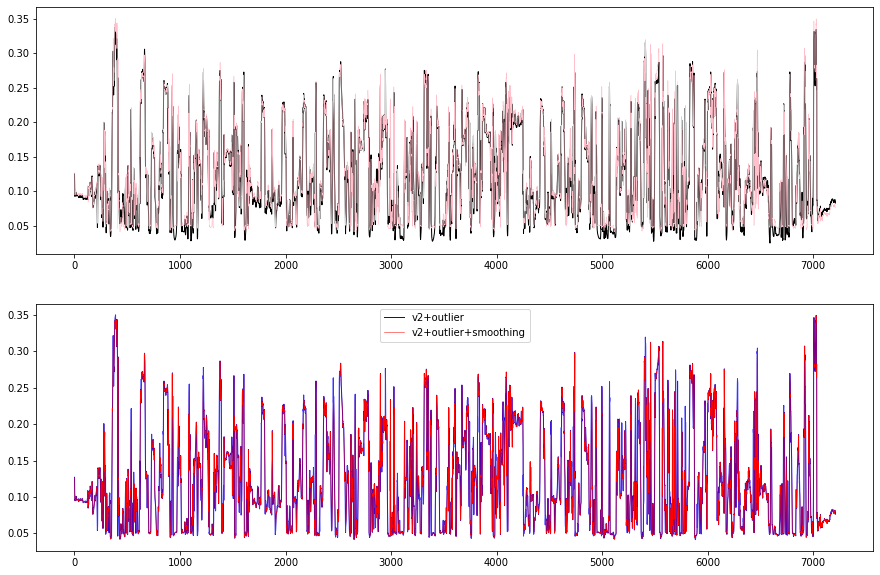

In [9]:
VIDEO_INDEX = 0
JOINT_INDEX = 10
X_OR_Y = 'x'
POSE_LIST = [poses1_norm, poses2_norm, poses3_norm, poses4_norm]
######
pose_list = [p[VIDEO_INDEX][...,:34].reshape(-1,17,2) for p in POSE_LIST] # v1, v2, v3, v4
if X_OR_Y == 'x':
    coord_to_plot = [p[..., JOINT_INDEX, 0] for p in pose_list]
elif X_OR_Y == 'y':
    coord_to_plot = [p[..., JOINT_INDEX, 1] for p in pose_list]

labels = ['v1', 'v2', 'v2+outlier', 'v2+outlier+smoothing']
colors = ['black', 'pink', 'blue','red']
linewidths = [1., .5, 1., .5]

plt.figure(figsize=(15,10))
for i, coord in enumerate(coord_to_plot):
    plt.subplot(2, 1, i//2 + 1)
    plt.plot(coord, linewidth=linewidths[i], label=labels[i], c=colors[i])
    if i // 2 == 1:
        plt.legend()
# plt.legend()
plt.show()

## result
* preprocess v2를 적용하면 clipping 현상이 발생함
* 그래프 상으로는 preprocess v1 + normalize (+@) 적용하는 것이 바람직해 보임

### preprocess v1 옵션별 시각화
* 기본
* 노말라이즈
* 아웃라이어 인터폴레이션 + 노말라이즈
* 아웃라이어 인터폴레이션 + 스무딩 + 노말라이즈

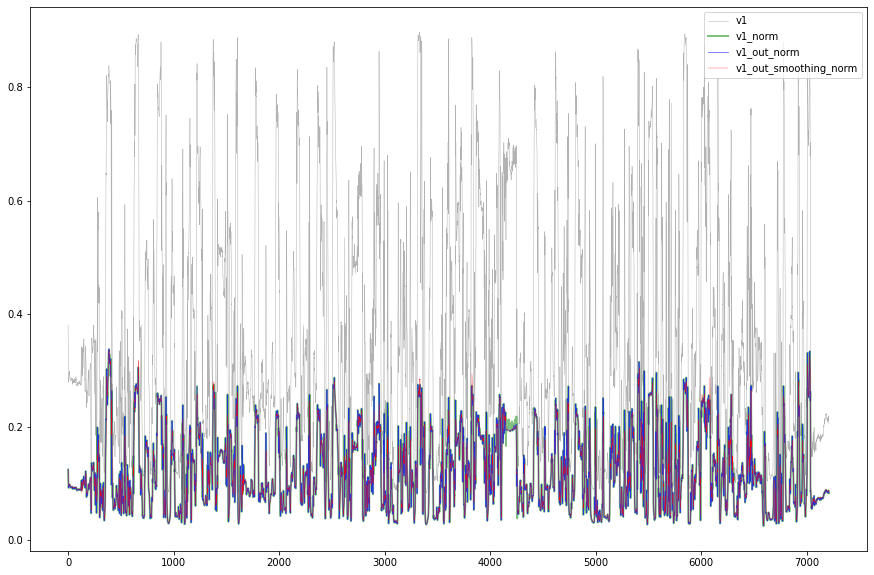

In [10]:
VIDEO_INDEX = 0
JOINT_INDEX = 10
X_OR_Y = 'x'
POSE_LIST = [poses1, poses1_norm, poses1_outlier_norm, poses1_outlier_smoothing_norm]
######
pose_list = [p[VIDEO_INDEX][...,:34].reshape(-1,17,2) for p in POSE_LIST] # v1, v2, v3, v4
if X_OR_Y == 'x':
    coord_to_plot = [p[..., JOINT_INDEX, 0] for p in pose_list]
elif X_OR_Y == 'y':
    coord_to_plot = [p[..., JOINT_INDEX, 1] for p in pose_list]

labels = ['v1', 'v1_norm', 'v1_out_norm', 'v1_out_smoothing_norm']
colors = ['black', 'green', 'blue','red']
linewidths = [.5, 2.0, .7, .3]
alphas = [.3, .5, .7, 1.]

plt.figure(figsize=(15,10))
for i, coord in enumerate(coord_to_plot):
    plt.plot(coord, linewidth=linewidths[i], label=labels[i], c=colors[i], alpha=alphas[i])
plt.legend()
plt.show()

### visualize joint 2d

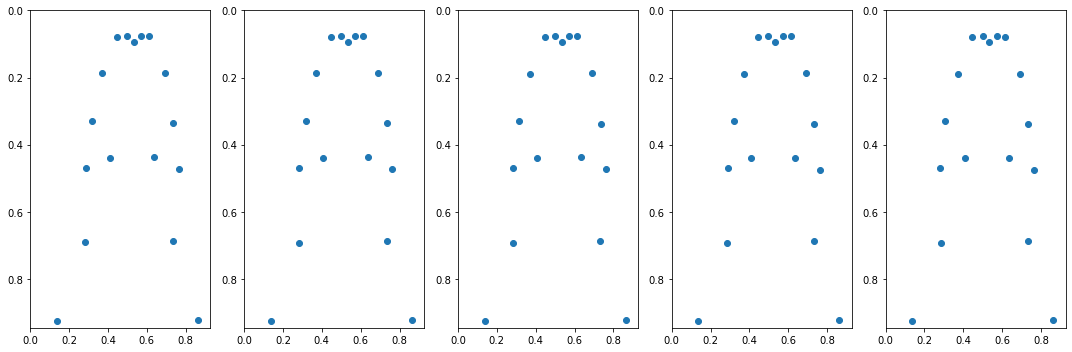

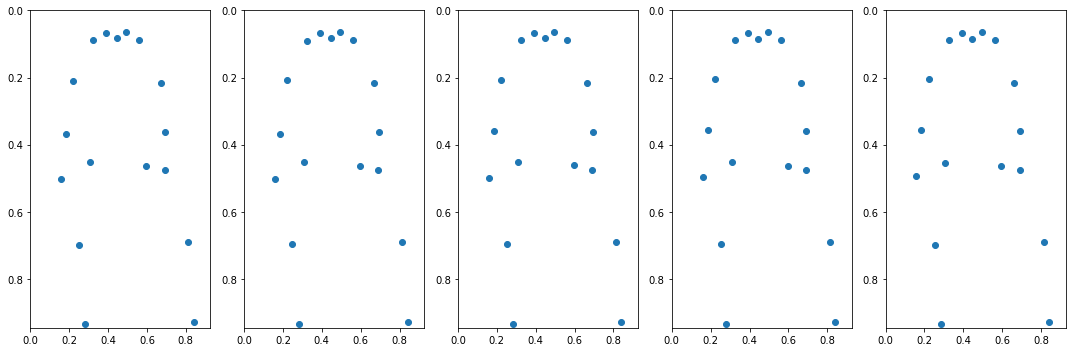

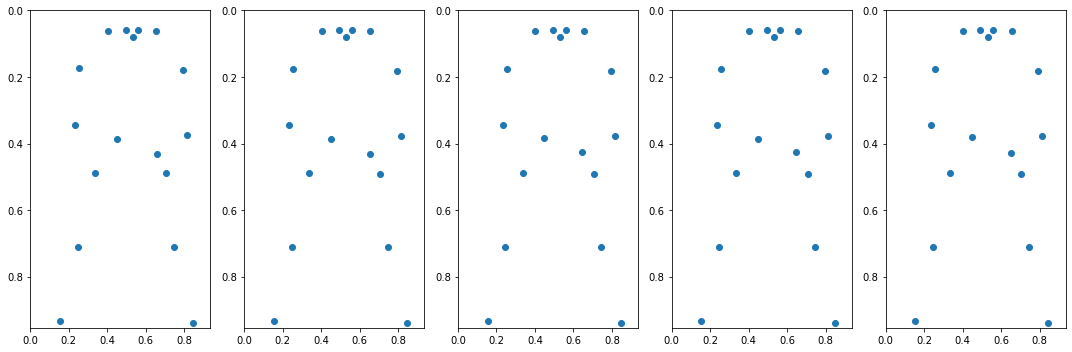

In [32]:
for i in range(3):
    visualize_joints(poses1[i], 35, 40)

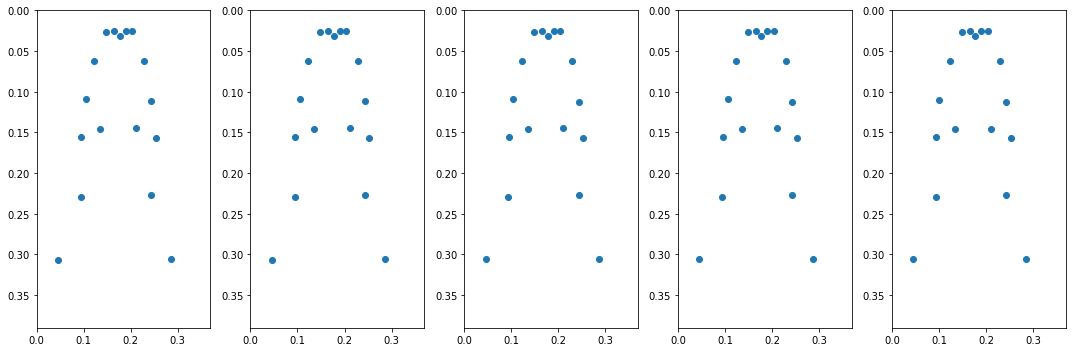

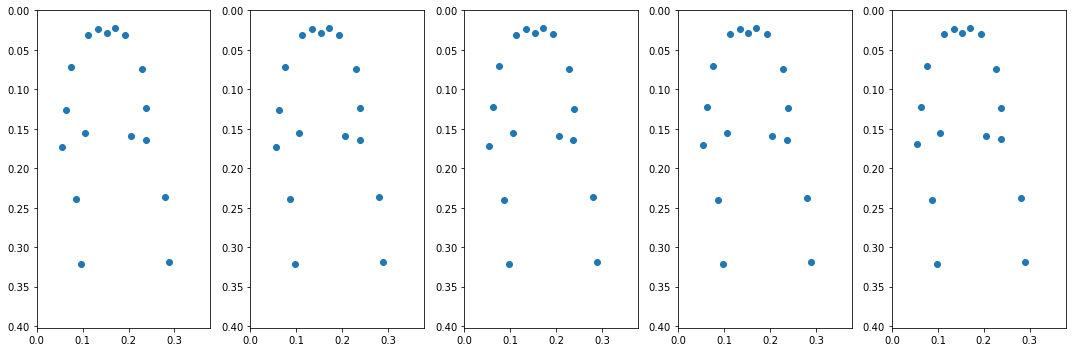

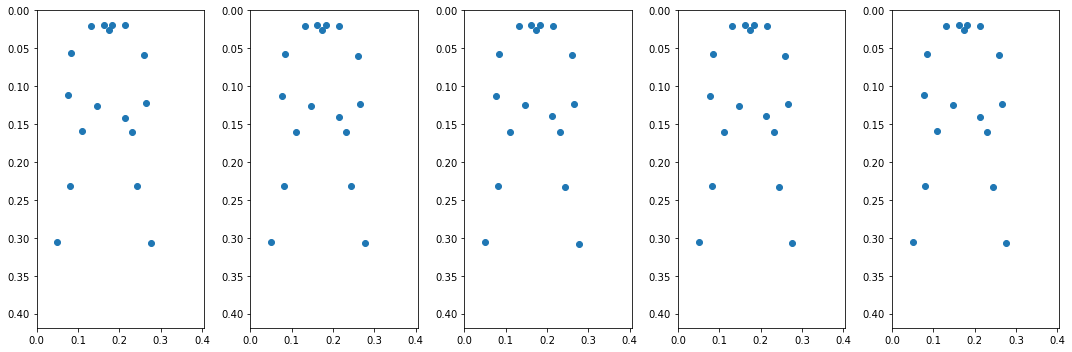

In [33]:
for i in range(3):
    visualize_joints(poses1_norm[i], 35, 40)

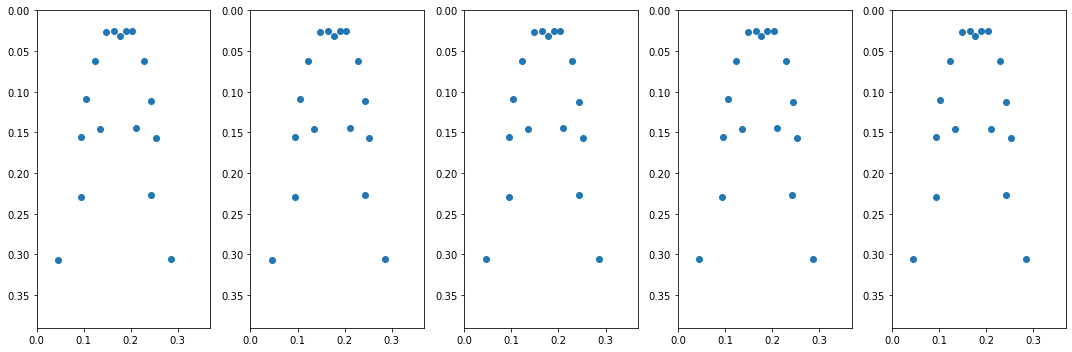

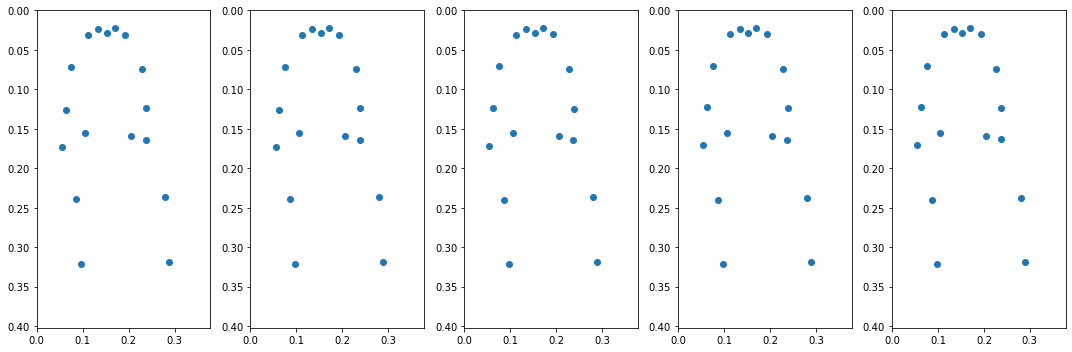

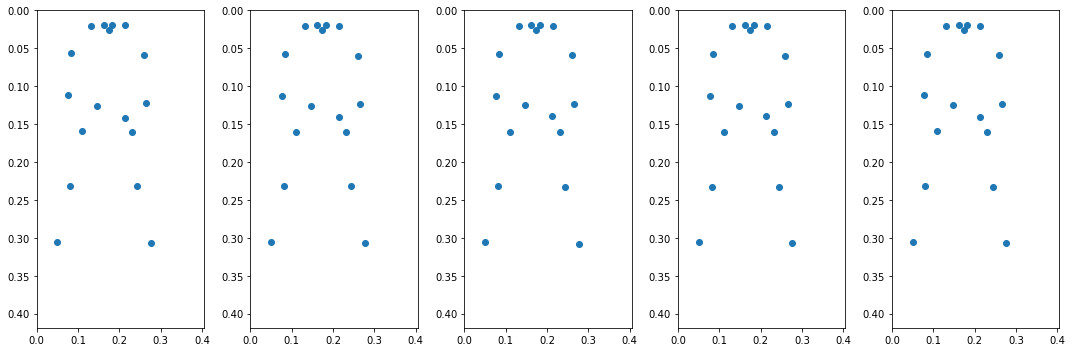

In [34]:
for i in range(3):
    visualize_joints(poses1_outlier_norm[i], 35, 40)

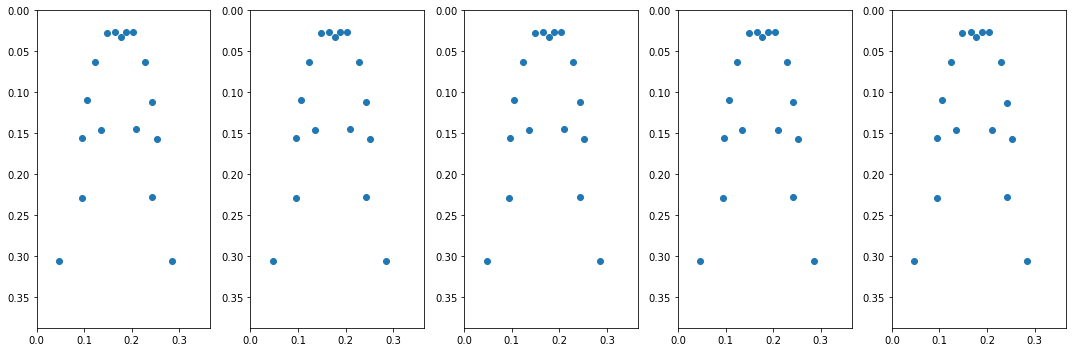

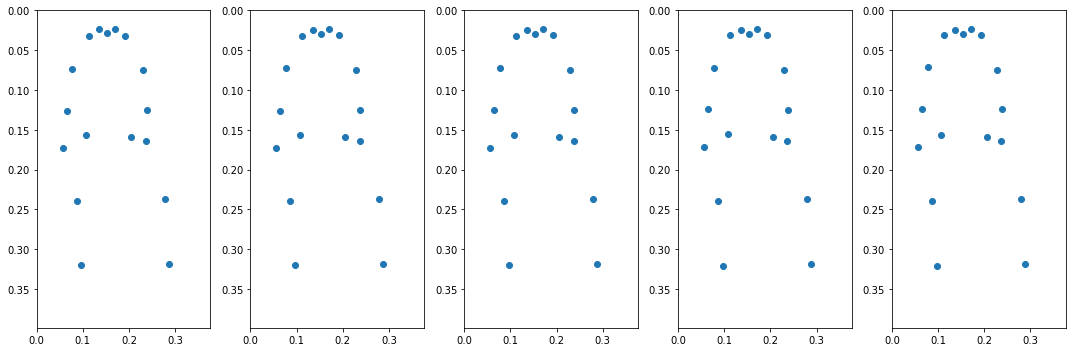

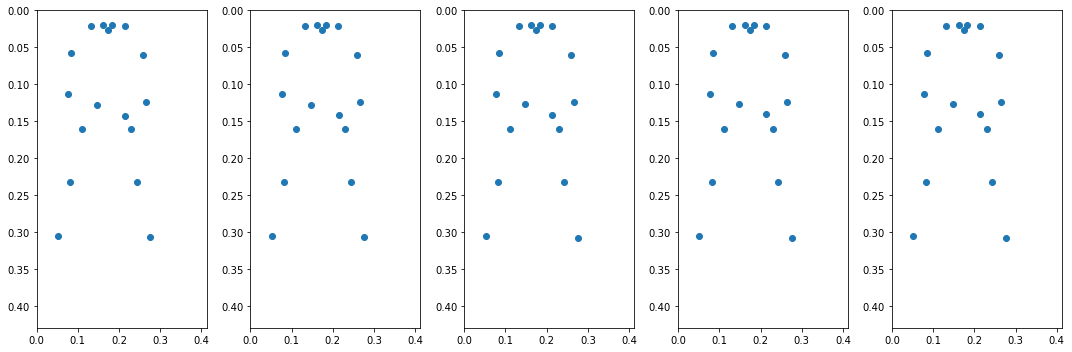

In [35]:
for i in range(3):
    visualize_joints(poses1_outlier_smoothing_norm[i], 35, 40)

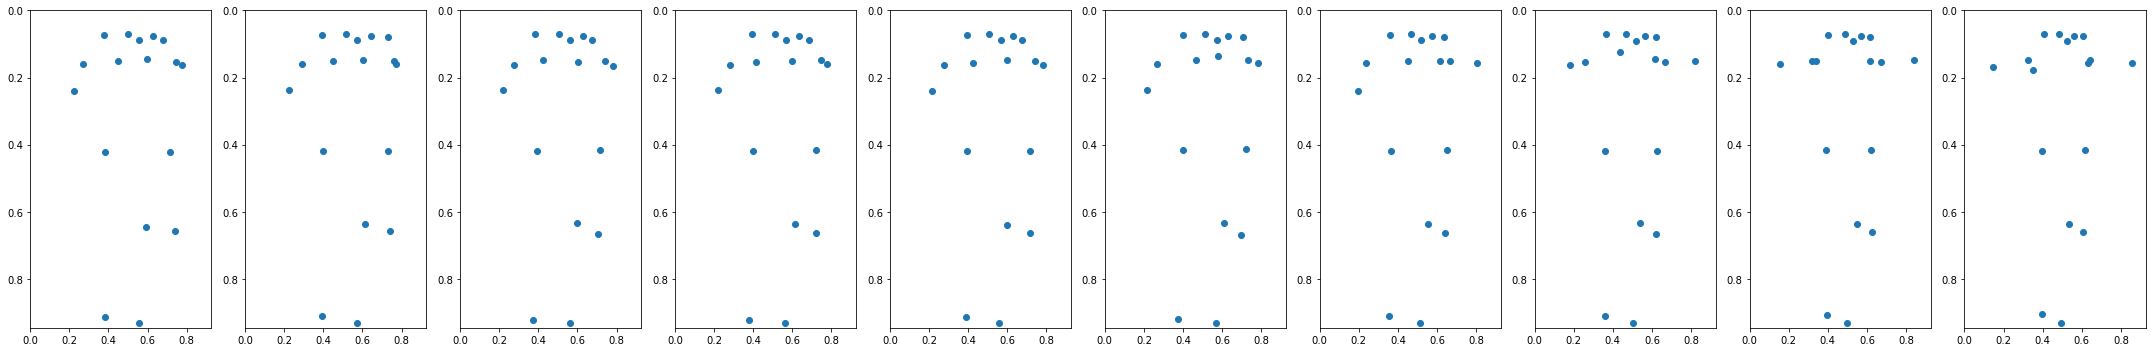

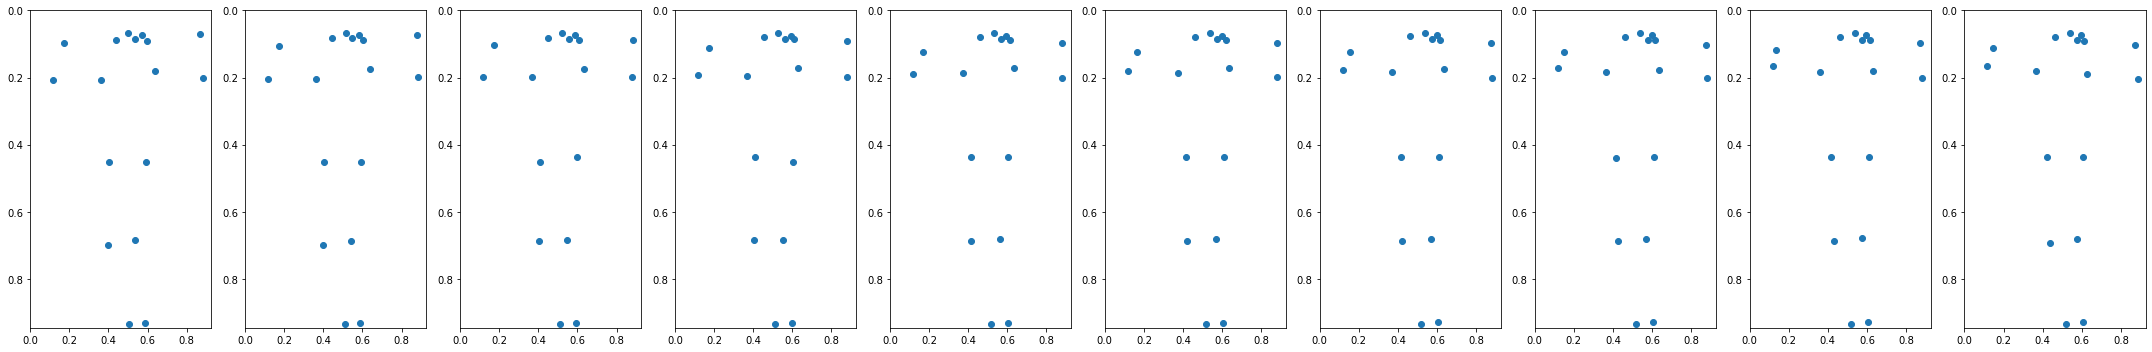

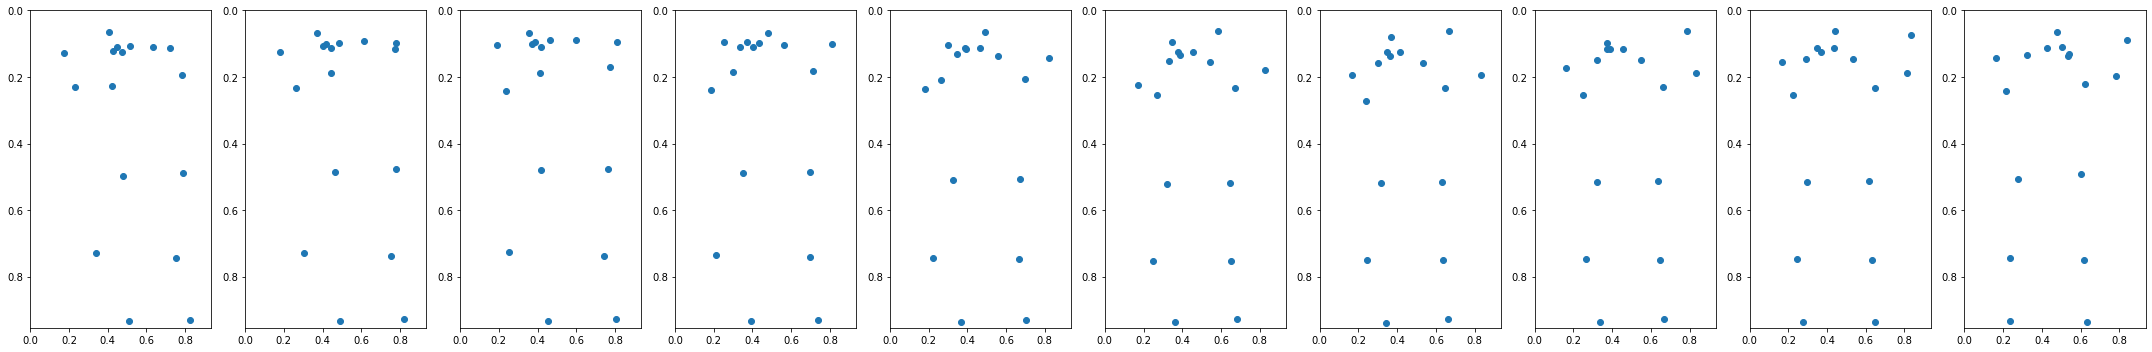

In [36]:
for i in range(3):
    visualize_joints(poses1[i], 1000, 1010)

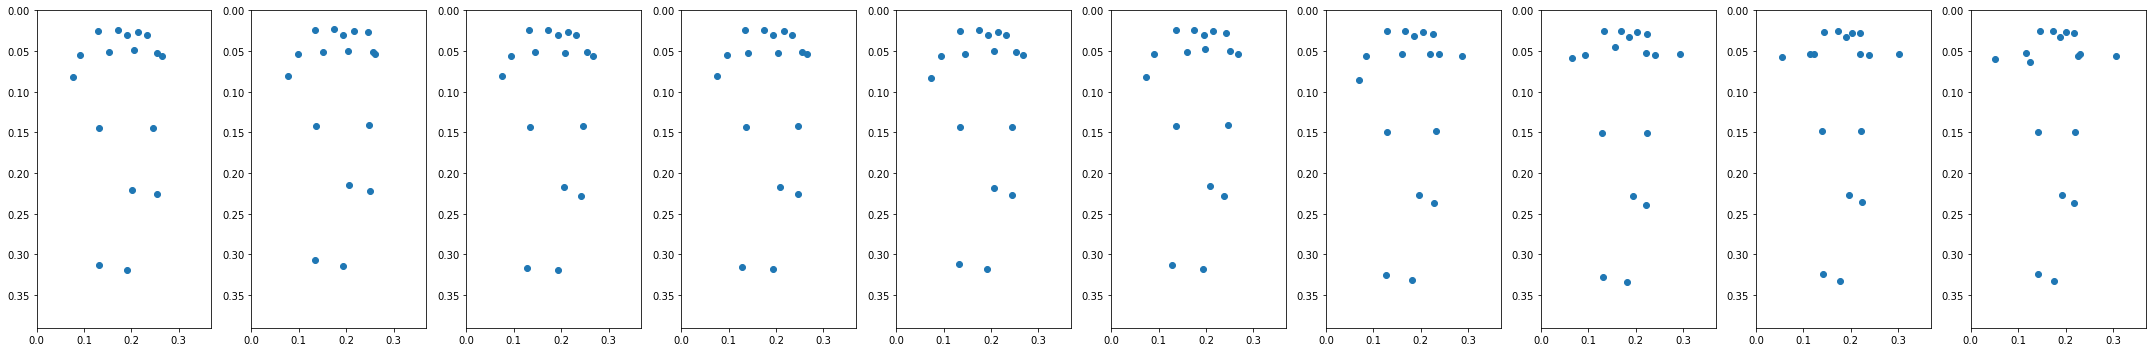

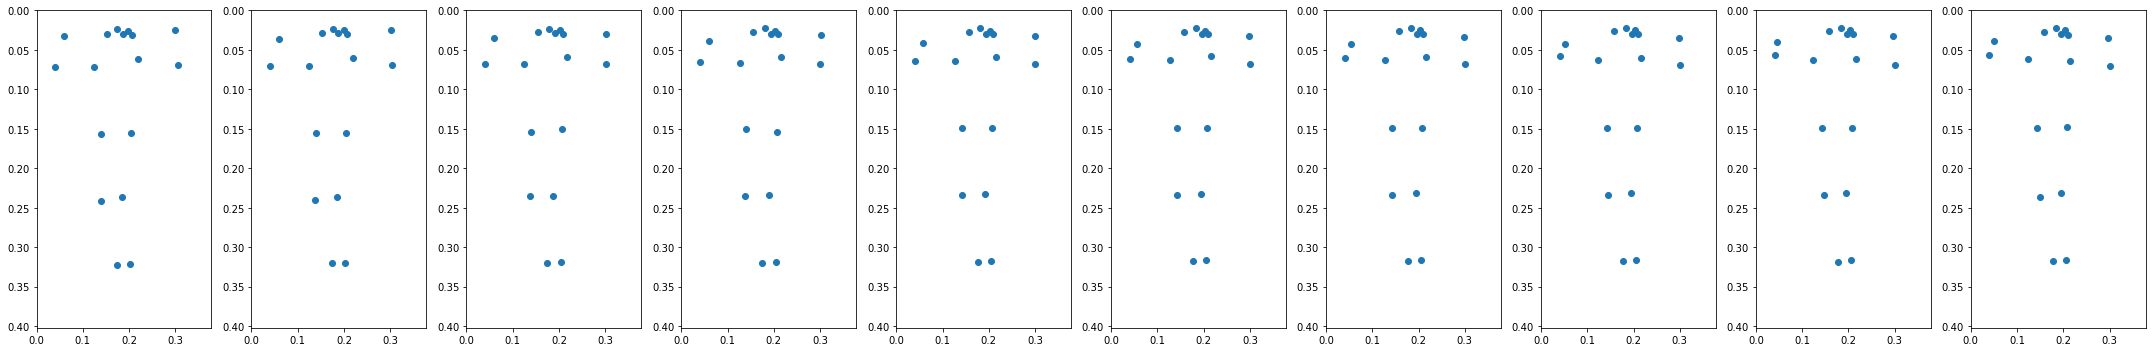

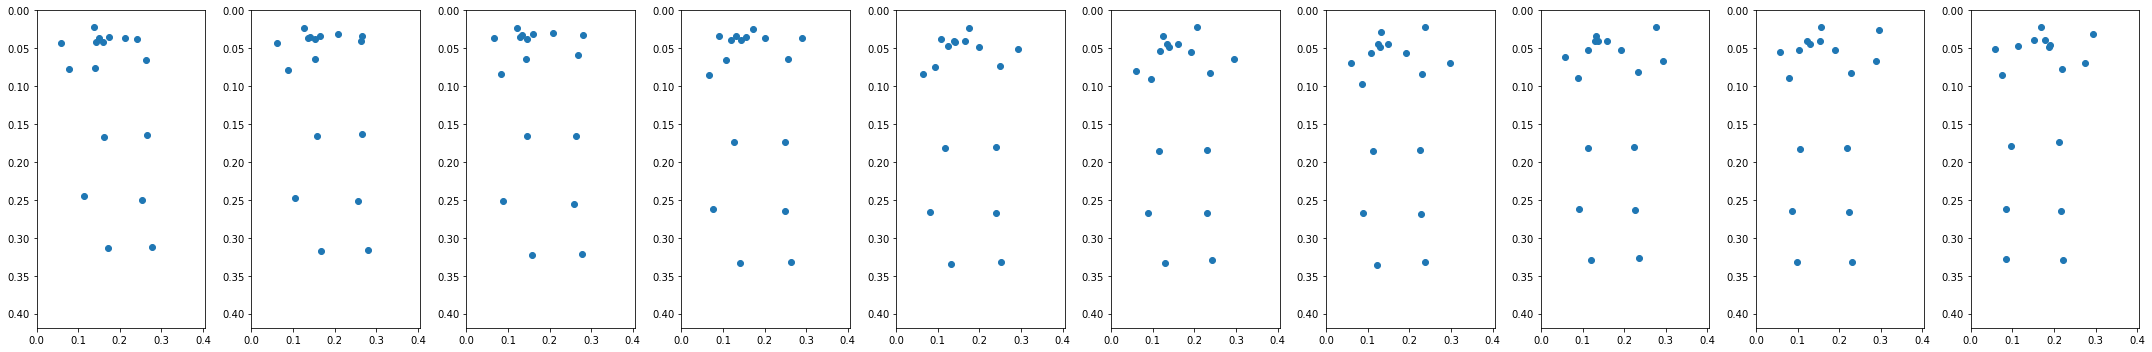

In [37]:
for i in range(3):
    visualize_joints(poses1_norm[i], 1000, 1010)

### feature extraction
* remove joint confidence score

In [8]:
# (num_frames, 34) -> (34,)
poses_svd = []
for pose in poses1:
    pose_xy = pose[...,:34]
    pose_index = pose[...,-1][0]
    pose_svd = extract_feature_svd(pose_xy)    
    pose_svd_with_index = np.concatenate([pose_svd, np.array([pose_index])])
    poses_svd.append(pose_svd_with_index)

In [9]:
print(poses_svd[0].shape)
poses_svd[0]

(35,)


array([2.46395615e+02, 2.39779564e+01, 2.16318354e+01, 1.73575329e+01,
       1.57066262e+01, 1.44011742e+01, 1.11667538e+01, 1.04689022e+01,
       8.78493985e+00, 8.29097371e+00, 6.68175430e+00, 6.24156066e+00,
       5.37130930e+00, 5.02901511e+00, 4.24284197e+00, 4.08919568e+00,
       3.93400643e+00, 3.25551864e+00, 3.12625884e+00, 2.74349301e+00,
       2.26458192e+00, 1.96724388e+00, 1.86587618e+00, 1.64846408e+00,
       1.35569813e+00, 1.04493207e+00, 7.65976513e-01, 6.99816351e-01,
       5.66742708e-01, 4.53110377e-01, 4.45445638e-01, 3.70548086e-01,
       1.85902927e-01, 1.39212145e-01, 0.00000000e+00])

In [ ]:
# (num_frames, 34) -> frame stretch (256, 34) -> (34,)


### vptree_move mirror setting (image search)

In [10]:
idx2vidname

{0: 'aespa1_frames_pose',
 1: 'aespa4_frames_pose',
 2: 'bts1_frames_pose',
 3: 'bts2_frames_pose',
 4: 'bts3_frames_pose',
 5: 'bts4_frames_pose',
 6: 'bts6_frames_pose',
 7: 'bts7_frames_pose',
 8: 'itzy11_frames_pose',
 9: 'itzy1_frames_pose',
 10: 'itzy2_frames_pose',
 11: 'itzy3_frames_pose',
 12: 'itzy4_frames_pose',
 13: 'itzy5_frames_pose',
 14: 'itzy6_frames_pose',
 15: 'itzy8_frames_pose',
 16: 'itzy9_frames_pose',
 17: 'jenny2_frames_pose',
 18: 'jenny3_frames_pose',
 19: 'jenny4_frames_pose',
 20: 'jenny5_frames_pose',
 21: 'twice1_frames_pose',
 22: 'twice3_frames_pose',
 23: 'twice4_frames_pose',
 24: 'twice7_frames_pose'}

In [11]:
query_index = [0, 2, 9, 17, 21] # 카테고리별 1개씩
data_index = [1, 3, 10, 18, 22] # 카테고리별 1개씩
queries = [poses1_norm[i] for i in query_index]
matchings = [poses1_norm[i] for i in data_index]

data = np.concatenate(matchings)
queries[0].shape, data.shape

((7213, 53), (20492, 53))

In [12]:
tree = vptree.VPTree(data, weighted_distance_matching)
result = tree.get_n_nearest_neighbors(queries[0][0], 10)
summarize_vptree_result(result, idx2vidname)

[('aespa4_frames_pose', 0.0036907775174810187),
 ('twice3_frames_pose', 0.004650561735492067),
 ('aespa4_frames_pose', 0.004658943681353505),
 ('bts2_frames_pose', 0.004767169981003477),
 ('aespa4_frames_pose', 0.005098614402187629),
 ('aespa4_frames_pose', 0.005349777035151391),
 ('aespa4_frames_pose', 0.005690096795427226),
 ('aespa4_frames_pose', 0.005977187835911394),
 ('aespa4_frames_pose', 0.006031250847792764),
 ('bts2_frames_pose', 0.006076008943382706)]

### vptree_move mirror multiple searching
* idx2vidname

In [13]:
vptree_search(tree, idx2vidname, queries[0], 2000, 2200, 5, 5) # query0 -> aespa1 2000 ~ 2200 frames

[('aespa4_frames_pose', 4.177380059129694e+251),
 ('jenny3_frames_pose', 2.7484708333830323e+79),
 ('bts2_frames_pose', 1.3236567924499965e+55),
 ('twice3_frames_pose', 2.0282161105472597e+38),
 ('itzy2_frames_pose', 3.0667065836491943e+25)]

In [14]:
vptree_search(tree, idx2vidname, queries[2], 1000, 1200, 10, 5) # query2 -> itzy1 1000~1200 frames

[('itzy2_frames_pose', 6.004826095664623e+97),
 ('bts2_frames_pose', 2.529443640139367e+48),
 ('aespa4_frames_pose', 1.534069227821526e+36),
 ('twice3_frames_pose', 2.9068357008251965e+20),
 ('jenny3_frames_pose', 59046380163.40111)]

In [15]:
vptree_search(tree, idx2vidname, queries[1], 800, 1400, 20, 5) # query1 -> bts6 800 ~ 1400 frames

[('bts2_frames_pose', 1.4125558309445482e+147),
 ('aespa4_frames_pose', 3.542049676127312e+98),
 ('twice3_frames_pose', 3.39056316059726e+31),
 ('jenny3_frames_pose', 3.1127134880980956e+23),
 ('itzy2_frames_pose', 6.726634366285256e+20)]

### vptree_default data
* all data must have the same shape (ex. (256, 53))

In [16]:
query_index = [0, 2, 9, 17, 21]
data_index = [1, 3, 4, 10, 11, 18, 19, 22, 23]

# all data must have the same length
queries = [poses1[i][:100,...] for i in query_index]
matchings = [poses1[i][:100,...] for i in data_index]

data = np.stack(matchings)
queries[0].shape, data.shape

((100, 53), (9, 100, 53))

In [17]:
tree = vptree.VPTree(data, cosine_dist_xy_flatten)
result = tree.get_n_nearest_neighbors(queries[0], 5)
summarize_vptree_result(result, idx2vidname)

[('aespa4_frames_pose', 0.013485524987794206),
 ('bts2_frames_pose', 0.09683963077460922),
 ('itzy2_frames_pose', 0.22782697953775444),
 ('bts3_frames_pose', 0.2539285225853185),
 ('itzy3_frames_pose', 0.28453557013887354)]

### vptree_feature data

In [18]:
query_index = [0, 2, 9, 17, 21]
data_index = [1, 3, 4, 10, 11, 18, 19, 22, 23]

queries = [poses_svd[i] for i in query_index]
matchings = [poses_svd[i] for i in data_index]

data = np.stack(matchings)
queries[0].shape, data.shape

((35,), (9, 35))

In [19]:
tree = vptree.VPTree(matchings, simple_minus)
result = tree.get_n_nearest_neighbors(queries[0], 5)
summarize_vptree_result(result, idx2vidname)

[('aespa4_frames_pose', 17.990641342704816),
 ('bts2_frames_pose', 44.308282360463544),
 ('itzy3_frames_pose', 115.77509361755037),
 ('jenny4_frames_pose', 116.22582472137586),
 ('bts3_frames_pose', 145.48849366352857)]